# Brain Age Prediction Challenge using diffusion MRI structural connectivity features

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact
import time

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
import seaborn as sns

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
import torch.nn as nn
from torch.nn import BatchNorm2d
from torch.nn import Dropout2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import LeakyReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import L1Loss, SmoothL1Loss
from torch.optim import SGD, Adam, Rprop, AdamW
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
 
import torchvision.transforms as transforms 
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchinfo import summary

from IPython.display import display
from livelossplot import PlotLosses

np.random.seed(0) 
torch.manual_seed(0)
import random
random.seed(0)

## Constantes

In [3]:
#path para guardar o dataset
PATH_TRAIN = './train.csv'
PATH_TEST = './test.csv'

#não estão a ser utilizados para já
device = torch.device("cpu") 

BATCH_SIZE = 1
EPOCHS = 100
LEARNING_RATE = 0.001

## Device Management

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
print(device)

cuda


## 1. Preparar os Dados

### 1.1 Leitura das matrizes de conetividade cerebral

In [5]:
train_mat = scipy.io.loadmat('train_data.mat') 
test_mat = scipy.io.loadmat('test_data.mat') 

In [6]:
def get_data_from_mat(train_file,test_file):
    train_mat = scipy.io.loadmat(train_file) 
    test_mat = scipy.io.loadmat(test_file) 
    print(train_mat.keys())
    print(test_mat.keys())
    train_np = np.array(train_mat['train_data']).transpose(2,0,1)
    test_np = np.array(test_mat['test_data']).transpose(2,0,1)
    train_np = np.float32(train_np)
    test_np = np.float32(test_np)
    print(train_np.shape)
    print(test_np.shape)
    return  train_np, test_np

train_data, test_data = get_data_from_mat('train_data.mat','test_data.mat')

dict_keys(['__header__', '__version__', '__globals__', 'train_data'])
dict_keys(['__header__', '__version__', '__globals__', 'test_data'])
(112, 90, 90)
(28, 90, 90)


In [7]:
print(train_data[0])

[[0.         0.         0.13152513 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.13152513 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.28060624]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.28060624 0.         0.        ]]


In [8]:
mat = scipy.io.loadmat('train_data.mat')
pqr=pd.Series(mat)
pd.DataFrame({'label':pqr.index, 'list':pqr.values})

,label,list
0,__header__,"b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Crea..."
1,__version__,1.0
2,__globals__,[]
3,train_data,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [9]:
print(pqr)

__header__     b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Crea...
__version__                                                  1.0
__globals__                                                   []
train_data     [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
dtype: object


### 1.2 Visualização das matrizes de conetividade cerebral

In [10]:
def visualize(image):  
    #plt.figure("sample", (12, 6))
    #plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")    
    #plt.subplot(1, 2, 2)
    #plt.imshow(image, cmap="gray")
    plt.show()      


#@interact
def show_ds(ds):
    print("ds shape:",ds.shape)
    print("ds max:",np.max(ds))
    print("ds min:",np.min(ds))
    print("ds average:",np.average(ds))
    @interact
    def visualize_set(scan_index=(0,len(ds)-1)):
        #print(scan_index)
        visualize(ds[scan_index,:,:])

show_ds(train_data)

ds shape: (112, 90, 90)
ds max: 1.0
ds min: 0.0
ds average: 0.024116168


interactive(children=(IntSlider(value=55, description='scan_index', max=111), Output()), _dom_classes=('widget…

In [11]:
show_ds(test_data)

ds shape: (28, 90, 90)
ds max: 1.0
ds min: 0.0
ds average: 0.024994023


interactive(children=(IntSlider(value=13, description='scan_index', max=27), Output()), _dom_classes=('widget-…

### 1.3 Preparação dos dataloaders

In [12]:
class CSVDataset(Dataset):
    # ler o dataset
    def __init__(self, path_train, path_test):

        # ler o ficheiro csv para um dataframe
        df_train = pd.read_csv(path_train, header=0)
        df_test = pd.read_csv(path_test, header=0)
        
        #Normalização da coluna da education
        df_train["education"] = (df_train["education"] - df_train["education"].min()) / (df_train["education"].max() - df_train["education"].min())    
        df_test["education"] = (df_test["education"] - df_test["education"].min()) / (df_test["education"].max() - df_test["education"].min())    
        
        #creating instance of one-hot-encoder
        encoder = OneHotEncoder(handle_unknown='ignore')

        #perform one-hot encoding on 'sex' column 
        encoder_df_train = pd.DataFrame(encoder.fit_transform(df_train[['sex']]).toarray())
        encoder_df_test = pd.DataFrame(encoder.fit_transform(df_test[['sex']]).toarray())

        #merge one-hot encoded columns back with original DataFrame
        df_train = df_train.join(encoder_df_train)
        df_test = df_test.join(encoder_df_test)
        
        #drop 'sex' column
        df_train.drop('sex', axis=1, inplace=True)
        df_test.drop('sex', axis=1, inplace=True)
    
        # separar os inputs e os outputs
        self.train = df_train.values[:, 2:]
        self.y = df_train.values[:,1]
        self.test = df_test.values[:, 1:]
    
        # garantir que os inputs e labels sejam floats 
        self.train = self.train.astype('float32')
        self.y = self.y.astype('float32')
        self.test = self.test.astype('float32')

    # número de casos no dataset
    def __len__(self):
        return len(self.x)
    
    # retornar um caso
    def __getitem_test__(self, idx):
        return [self.test[idx]]
    
    # retornar índices para casos de treino e de teste em formato flat (vetor)
    def get_splits_flat(self, train_data, test_data):
        #Dados do excel
        train = torch.from_numpy(np.array(self.train))
        y = torch.from_numpy(np.array(self.y))
        test = torch.from_numpy(np.array(self.test))

        #Dados das matrizes
        train_data = train_data.reshape(len(train_data), 1, 90, 90) 
        train_data  = torch.from_numpy(train_data)
        test_data = test_data.reshape(len(test_data), 1, 90, 90) 
        test_data  = torch.from_numpy(test_data)
        
        train = torch.utils.data.TensorDataset(train, train_data, y)
        test = torch.utils.data.TensorDataset(test, test_data)
        
        return train, test
    
def prepare_data_loaders(path_train, path_test, train_data, test_data):
    # criar uma instância do dataset
    dataset = CSVDataset(path_train, path_test)
    # calcular split
    train, test = dataset.get_splits_flat(train_data, test_data)
    
    #separação de treino e validação
    train_size = int(0.9 * len(train))
    val_size = len(train) - train_size
    train, validation  = random_split(train, [train_size, val_size], generator=torch.Generator().manual_seed(42))

    # preparar data loaders
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True) #112 len(train)
    val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=True)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)

    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all

# preparar os dados
train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all = prepare_data_loaders(PATH_TRAIN, PATH_TEST, train_data, test_data)
# sanity check
print("Train")
train,train_data, y = next(iter(train_dl))
print(train.shape, train_data.shape, y.shape)
train, train_data, y = next(iter(train_dl))
print(train.shape, train_data.shape, y.shape)

print("Val")
train,train_data, y = next(iter(val_dl))
print(train.shape, train_data.shape, y.shape)
train, train_data, y = next(iter(val_dl))
print(train.shape, train_data.shape, y.shape)

Train
torch.Size([1, 3]) torch.Size([1, 1, 90, 90]) torch.Size([1])
torch.Size([1, 3]) torch.Size([1, 1, 90, 90]) torch.Size([1])
Val
torch.Size([1, 3]) torch.Size([1, 1, 90, 90]) torch.Size([1])
torch.Size([1, 3]) torch.Size([1, 1, 90, 90]) torch.Size([1])


## 2. Visualizar os Dados

In [13]:
def visualize_data(path):
    # criar uma instância do dataset
    df = pd.read_csv(path, header=0)
    display(df)

def visualize_dataset(train_dl, test_dl):
     
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Validação:{len(val_dl.dataset)}")
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    train, train_data, y = next(iter(train_dl)) #fazer uma iteração nos loaders para ir buscar um batch de casos
    print(f"Shape tensor batch casos treino, input: {train.shape}, {train_data.shape}, output: {y.shape}")
    train, train_data, y = next(iter(val_dl)) #fazer uma iteração nos loaders para ir buscar um batch de casos
    print(f"Shape tensor batch casos validação, input: {train.shape}, {train_data.shape}, output: {y.shape}")
    print(f'Valor máximo no train:{torch.max(train)} Valor mínimo:{torch.min(train)}')
    print(f'Valor máximo na matriz :{torch.max(train_data)} Valor mínimo:{torch.min(train_data)}')
    print(f'Valor máximo na idade :{torch.max(y)} Valor mínimo:{torch.min(y)}')
    train=train.detach().numpy()
    train_data=train_data.detach().numpy()
    print(f'Valor máximo no train:{np.max(train)} Valor mínimo:{np.min(train)}')
    print(f'Valor máximo na matriz:{np.max(train_data)} Valor mínimo:{np.min(train_data)}')
    print(y)
    
visualize_data(PATH_TRAIN)
visualize_dataset(train_dl, test_dl)

,id,age,sex,education
0,1,13,1,7
1,2,14,0,8
2,3,15,1,9
3,4,15,1,9
4,5,15,1,9
...,...,...,...,...
107,108,77,1,4
108,109,67,0,4
109,110,55,0,4
110,111,76,1,3


Quantidade de casos de Treino:100
Quantidade de casos de Validação:12
Quantidade de casos de Teste:28
Shape tensor batch casos treino, input: torch.Size([1, 3]), torch.Size([1, 1, 90, 90]), output: torch.Size([1])
Shape tensor batch casos validação, input: torch.Size([1, 3]), torch.Size([1, 1, 90, 90]), output: torch.Size([1])
Valor máximo no train:1.0 Valor mínimo:0.0
Valor máximo na matriz :1.0 Valor mínimo:0.0
Valor máximo na idade :53.0 Valor mínimo:53.0
Valor máximo no train:1.0 Valor mínimo:0.0
Valor máximo na matriz:1.0 Valor mínimo:0.0
tensor([53.])


## 3. Verificar balanceamento do dataset

casos_treino:  100
Média_valores_label_Train:  44.03
casos_validacao:  12
Média_valores_label_Val:  46.666668


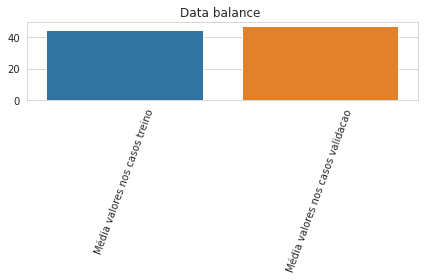

In [14]:
def visualize_holdout_balance(y_train, y_test, val_test):
    _, _, y_train = next(iter(train_dl_all))
    _, _, y_val = next(iter(val_dl_all))
    sns.set_style('whitegrid')
    casos_treino=len(y_train) 
    casos_validacao=len(y_val)
    print("casos_treino: ",casos_treino)
    print("Média_valores_label_Train: ", np.mean(y_train.numpy()))
    print("casos_validacao: ",casos_validacao)
    print("Média_valores_label_Val: ", np.mean(y_val.numpy()))
    grafico=sns.barplot(x=['Média valores nos casos treino', 'Média valores nos casos validacao'], 
    y=[np.mean(y_train.numpy()), np.mean(y_val.numpy())])
    grafico.set_title('Data balance ')
    plt.xticks(rotation=70)
    plt.tight_layout()
    #plt.savefig('data_balance_MLP.png')
    plt.show() 

visualize_holdout_balance(train_dl_all, test_dl_all, val_dl_all)

## 4. Definir o Modelo

In [15]:
# Definição classe para o modelo
class CNNModel(Module):
    # definir elementos do modelo
    def __init__(self):
        super(CNNModel, self).__init__()
        self.layer1 = Sequential(Conv2d(in_channels=1, out_channels=50, kernel_size=(3,3)),
                                 BatchNorm2d(50),
                                 LeakyReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                ) 
        self.layer2 = Sequential(Conv2d(in_channels=50, out_channels=100, kernel_size=(3,3)),
                                 BatchNorm2d(100),
                                 LeakyReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                )
        self.layer3 = Sequential(Conv2d(in_channels=100, out_channels=200, kernel_size=(3,3)),
                                 BatchNorm2d(200),
                                 LeakyReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                )
        self.layer4 = Sequential(Conv2d(in_channels=200, out_channels=200, kernel_size=(3,3)),
                                 BatchNorm2d(200),
                                 LeakyReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                )
        #MultiLayer Perceptron
        #São 32 pois saem 32 canais. É 5*5, 28-2kernel(layer1)/2stride = 13-2 = 11/2 = 5.5 = 5
        #self.drop1 = nn.Dropout2d(0.30)
        self.fc1 = Linear(in_features=1803, out_features=100) 
        kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.act1 = LeakyReLU()
        #self.drop2 = nn.Dropout2d(0.30)
        self.fc8 = Linear(100, 1)
        
        
    def forward(self, train, train_data):
        out = self.layer1(train_data)
        #print("out1", out.shape)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        #print("out2", out.shape)
        out = out.view(out.size(0), -1) 
        out = torch.cat([out, train], 1) 
        #print("out4", out.shape)
        #out = self.drop1(out)
        out = self.fc1(out)
        out = self.act1(out)
        #print("out6", out.shape)
        #out = self.drop2(out)
        out = self.fc8(out) 
        return out

# definir a rede neuronal
model = CNNModel()
# visualizar a rede
print(summary(model, input_size=((BATCH_SIZE,3), (BATCH_SIZE,1, 90, 90)), verbose=0)) 
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 1]                    --
├─Sequential: 1-1                        [1, 50, 44, 44]           --
│    └─Conv2d: 2-1                       [1, 50, 88, 88]           500
│    └─BatchNorm2d: 2-2                  [1, 50, 88, 88]           100
│    └─LeakyReLU: 2-3                    [1, 50, 88, 88]           --
│    └─MaxPool2d: 2-4                    [1, 50, 44, 44]           --
├─Sequential: 1-2                        [1, 100, 21, 21]          --
│    └─Conv2d: 2-5                       [1, 100, 42, 42]          45,100
│    └─BatchNorm2d: 2-6                  [1, 100, 42, 42]          200
│    └─LeakyReLU: 2-7                    [1, 100, 42, 42]          --
│    └─MaxPool2d: 2-8                    [1, 100, 21, 21]          --
├─Sequential: 1-3                        [1, 200, 9, 9]            --
│    └─Conv2d: 2-9                       [1, 200, 19, 19]          180,200
│  

CNNModel(
  (layer1): Sequential(
    (0): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(200, 200, kernel

## 5. Treinar o Modelo

In [16]:
def train_model(h5_file, train_dl, val_dl, model, criterion, optimizer, scheduler):
    liveloss = PlotLosses()
    for epoch in range(EPOCHS):
        logs = {} ##para o livelossplot
        #Train phase
        model.train() 
        running_loss  = 0.0
        for inputs, train_data, labels in train_dl: 
            inputs = inputs.to(device)
            train_data = train_data.to(device)
            labels = labels.to(device)
            outputs = model(inputs, train_data)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0) #multiplico por inputs.size(0) que é o batch desta iteração 
        epoch_loss = running_loss / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
            
        #Validation phase
        model.eval() 
        running_loss  = 0.0
        for inputs, train_data, labels in val_dl: 
            inputs = inputs.to(device)
            train_data = train_data.to(device)
            labels = labels.to(device)
            outputs = model(inputs, train_data)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * inputs.size(0) #multiplico por inputs.size(0) que é o batch desta iteração
        epoch_loss = running_loss / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        scheduler.step(epoch_loss) 
        epoch_lr = optimizer.param_groups[0]['lr'] 
        logs['val_lr'] = epoch_lr 
        liveloss.update(logs)
        liveloss.send()
    torch.save(model,h5_file) 

KeyboardInterrupt: 

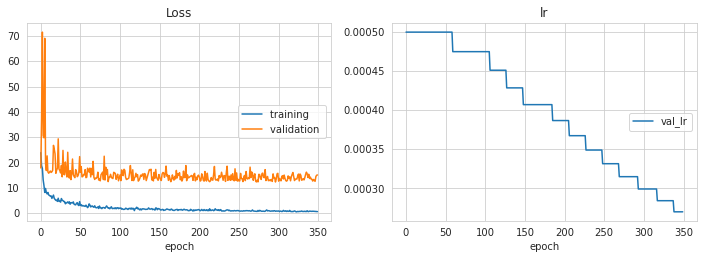

In [17]:
#treino do modelo CNNModel_1
EPOCHS = 1000
LEARNING_RATE = 0.0005
criterion = L1Loss()
#optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
#optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
#optimizer = Rprop(model.parameters(), lr=LEARNING_RATE)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.95, patience=20)
starttime = time.perf_counter()
train_model('CNNModel_1.pth', train_dl, val_dl, model, criterion, optimizer, scheduler)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

## 6. Testar o Modelo

In [ ]:
# Avaliar o modelo
def predict(test_dl, model):
    predictions = []
    previsoes = []
    for inputs, test_data in test_dl:
        # avaliar o modelo com os casos de teste
        inputs = inputs.to(device)
        test_data = test_data.to(device)
        yprev = model(inputs, test_data)
        
        # retirar o array numpy
        yprev = yprev.detach().cpu().numpy()

        # reshape for stacking
        yprev = yprev.reshape((len(yprev), 1))
        
        # guardar
        predictions.append(yprev)

    predictions = np.vstack(predictions)
    
    for i in predictions:
        previsoes.append(i[0])
    previsoes = np.array(previsoes)
    
    return previsoes

# testar o modelo
predictions = predict(test_dl, model)
print("Previsão", predictions)

In [ ]:
#Guardar os resultados num csv
ids = np.arange(1,29,1)

df = pd.DataFrame({"id" : ids, "age" : predictions})
df.to_csv("results.csv", index=False)